In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
import pickle
import torch
import numpy as np

from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs, numpy_to_torch, standardize, build_training_and_test_sets

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
###################### Load ERA5 data
lon, lat, lon_grid, lat_grid = extract_longitude_latitude() 
lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [5]:
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# merge runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [6]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33)

In [7]:
# import algorithms

from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, train_robust_weights_model, compute_weights


In [8]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

Loss function:  165689.0094905297
Loss function:  186128.07966246456
Loss function:  323214.0308265565
Loss function:  372972.63217736466


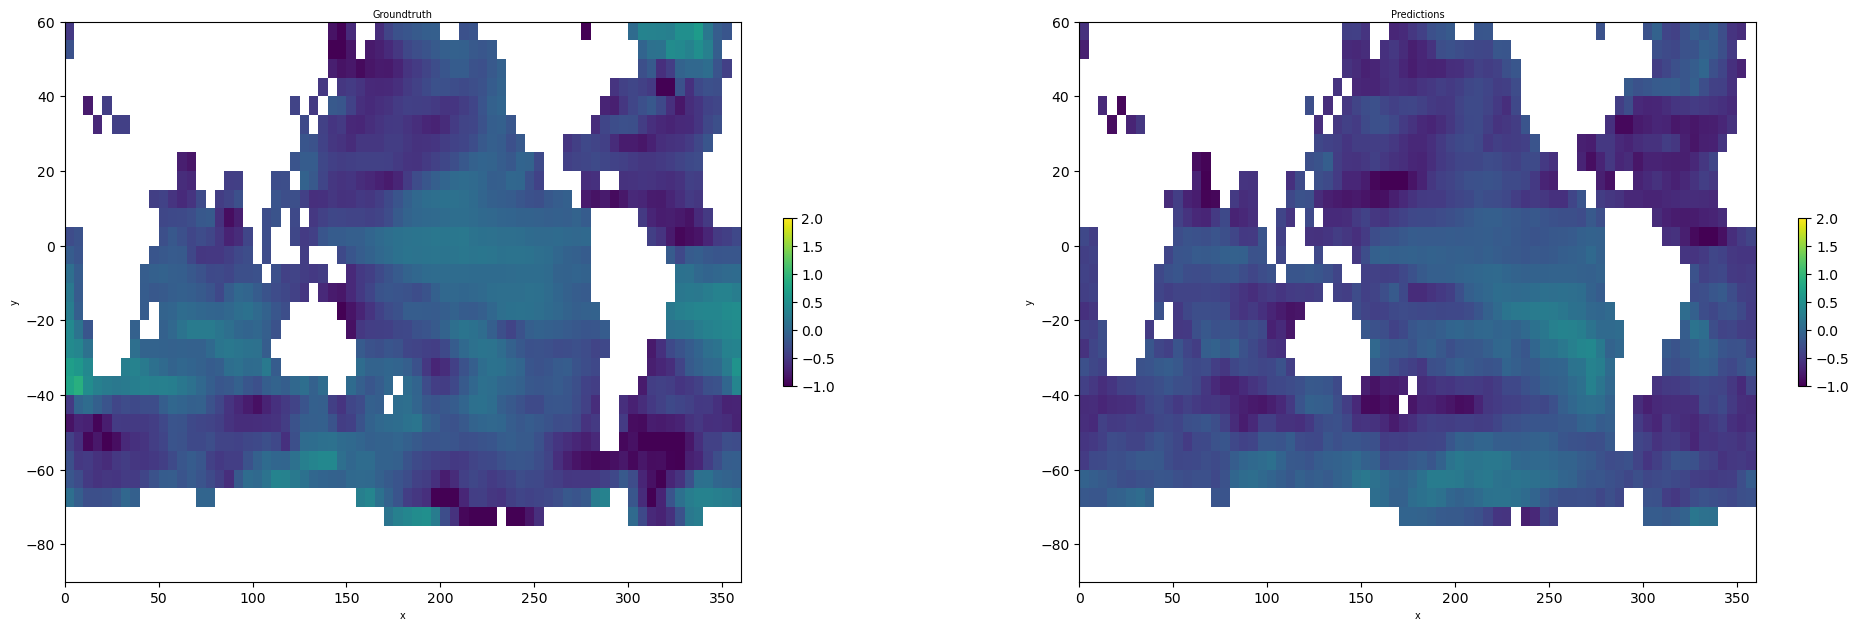

In [9]:
from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred

plot_gt_vs_pred(y_test,x_test,W_ridge,notnan_idx,nan_idx,lon_grid,lat_grid,time_idx=10)

In [10]:
w_robust, training_loss = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,rank=None,lambda_=1.0,mu_=1.0,lr=0.000001,nb_iterations=2)

Iteration  0 : Loss function :  46361.72265625
Iteration  1 : Loss function :  44251.76171875


In [11]:
weights = compute_weights(training_models,w_robust,x,y,notnan_idx,lambda_=1.0,mu_=1.0)

/home/vcohen/cope/src/algorithms.py:243: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


In [12]:
from leave_one_out import leave_one_out_single, leave_one_out_procedure

In [13]:
w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
                                                              lon_size,lat_size,notnan_idx,nan_idx,\
                                                              lr=0.000001,nb_gradient_iterations=2,time_period=33,\
                                                              rank=5,lambda_=100.0,method='robust',mu_=1000.0,verbose=True)

Iteration  0 : Loss function :  31155.740234375
Iteration  1 : Loss function :  26548.111328125


In [14]:
leave_one_out_procedure(x,y,vars,\
                        lon_size,lat_size, notnan_idx,nan_idx,\
                        lr=0.00001,nb_gradient_iterations=2,time_period=33,\
                        rank=5,lambda_=1.0,method='robust',mu_=1.0,verbose=True)

Iteration  0 : Loss function :  15950.392578125
Iteration  1 : Loss function :  12816.8896484375
RMSE (mean) on model  ICON-ESM-LR  :  0.7809368963126243
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  EC-Earth3  :  0.14887788725089127
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CMCC-CM2-SR5  :  0.2908584851205244
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  ACCESS-CM2  :  0.31178562373675367
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CESM2  :  0.25516011531371025
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CNRM-ESM2-1  :  0.18158350797392842
Sum of weights ==1 :  1.0


({'ICON-ESM-LR': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0005, 0.0005, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0005, 0.0006, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
         dtype=torch.float64),
  'EC-Earth3': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1991e-05, 4.7132e-05,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.7741e-05, 1.1650e-04,
           0.0000e+00],
         

In [15]:
from cross_validation import cross_validation_procedure

w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,lon_size,lat_size,notnan_idx,nan_idx,\
                            lr=0.00001,nb_gradient_iterations=2,time_period=33,\
                            rank=5,lambda_range=torch.tensor([1.0]),method='robust',mu_range=torch.tensor([1.0]),verbose=True)

Iteration  0 : Loss function :  15950.392578125
Iteration  1 : Loss function :  12816.8896484375
RMSE (mean) on model  ICON-ESM-LR  :  0.7809368963126243
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  EC-Earth3  :  0.14887788725089127
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CMCC-CM2-SR5  :  0.2908584851205244
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  ACCESS-CM2  :  0.31178562373675367
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CESM2  :  0.25516011531371025
Iteration  0 : Loss function :  31132.552734375
Iteration  1 : Loss function :  26483.955078125
RMSE (mean) on model  CNRM-ESM2-1  :  0.18158350797392842
Sum of weights ==1 :  1.0
